This notebook is for further investigation of the Potts model in predicting protein fitness with MSA. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model import CouplingsModel
import tools
import scipy
from pathlib import Path
from collections import OrderedDict
# biopython SeqIO
from Bio import SeqIO
from sklearn.metrics import roc_auc_score
import scipy

In [47]:
ALPHABET_PROTEIN = '-ACDEFGHIKLMNPQRSTVWY'
def check_sequence(s, alphabet=ALPHABET_PROTEIN):
    for aa in s:
        if aa not in ALPHABET_PROTEIN:
            return False
    return True
def model_info(c):
    print("Number of sites: ", c.L)
    print("Number of valid sequences: ", c.N_valid)
    print("Number of invalid sequences: ", c.N_invalid)
    print("Number of valid sequences: ", c.N_valid)

In [14]:
NAME = 'PABP_YEAST'

### training code for model, uncomment the following line: 
#!plmc/bin/plmc -o PABP_YEAST/model/{NAME}.model_params -c PABP_YEAST/model/{NAME}.txt -f PABP_YEAST -le 16.2 -lh 0.01 -m 200 -t 0.2 -g PABP_YEAST/data/{NAME}.a2m
c = CouplingsModel("PABP_YEAST/model/PABP_YEAST.model_params")
c2 = CouplingsModel("PABP_YEAST/model/PABP_YEAST_10000.model_params")

In [15]:
# read the experimental mutational scanning dataset for PABP by Melamed et al., RNA, 2013
data = pd.read_csv(
    "PABP_YEAST/data/PABP_YEAST_Fields2013-singles.csv", sep=";", comment="#"
)
# wt = {"mutant": "wild", "linear": 0, "log": 0}
# data = data.append(wt, ignore_index=True)

In [21]:
print(c.weights.shape)
print(c2.weights.shape)

w_full = c.weights
w_10000 = c2.weights

(152041,)
(10000,)


In [101]:
cnt = 0
for i in range(c.weights.shape[0]):
    if w_full[i] == 0:
        cnt+=1
        continue
    w_full[i] = 1/w_full[i]
for i in range(c2.weights.shape[0]):
    if w_full[i] == 0: 
        continue
    w_10000[i] = 1/w_10000[i]

In [42]:
model_info(c)

Number of sites:  82
Number of valid sequences:  151496
Number of invalid sequences:  545
Number of valid sequences:  151496


In [43]:
151496+545

152041

In [25]:
# predict mutations using our model
data_pred = tools.predict_mutation_table(
    c, data, "effect_prediction_epistatic"
)

# can also add predictions by the corresponding independent model
c0 = c.to_independent_model()

data_pred = tools.predict_mutation_table(
    c0, data_pred, "effect_prediction_independent"
)
print(data_pred.head())
pred = data_pred['effect_prediction_epistatic']
pred_ind = data_pred['effect_prediction_independent']
label = data_pred['linear']
print('Evmutation spearman: ', scipy.stats.spearmanr(pred, label))
print('Independent control spearman: ', scipy.stats.spearmanr(pred_ind, label))

  mutant    linear       log  effect_prediction_epistatic  \
0  G126A  0.711743 -0.490571                    -2.597435   
1  G126C  0.449027 -1.155127                    -5.653770   
2  G126E  0.588928 -0.763836                    -6.589126   
3  G126D  0.229853 -2.121218                    -7.249220   
4  G126N  0.679435 -0.557593                    -5.799652   

   effect_prediction_independent  
0                       0.406487  
1                      -0.027602  
2                      -1.827570  
3                      -1.180076  
4                       0.387440  
Evmutation spearman:  SpearmanrResult(correlation=0.59280030296668, pvalue=1.2266190417209348e-113)
Independent control spearman:  SpearmanrResult(correlation=0.4236780791119215, pvalue=6.077688379018816e-53)


In [26]:
yeast_seq_str = []
fasta_sequences = SeqIO.parse(open("PABP_YEAST/data/PABP_YEAST.a2m"),'fasta')
for fasta in fasta_sequences:
    yeast_seq_str.append(str(fasta.seq))

In [62]:
pos_upper = [x for x in range(len(yeast_seq_str[0])) if not yeast_seq_str[0][x].islower()]
processed_yeast = np.asarray([np.asarray(list(s))[pos_upper] for s in yeast_seq_str if not 'x' in s])
processed_yeast = np.asarray([s for s in processed_yeast if check_sequence(s) and len(s)==82])
print(processed_yeast.shape)
wildtype = yeast_seq_str[0]

(151496, 82)


In [63]:
print(len(yeast_seq_str))
print(processed_yeast.shape)

152041
(151496, 82)


In [29]:
mutant, label = data['mutant'].to_numpy(), data['linear'].to_numpy()
mutant_data = []
for m in mutant:
    if m == 'wild':
        mutant_data.append(np.asarray(list(wildtype))[pos_upper])
        continue
    original_aa, loc, mutant_aa = m[0], int(m[1:4])-115, m[4]
    assert wildtype[loc] == original_aa
    mut_seq = np.asarray(list(wildtype[:loc]+mutant_aa+wildtype[loc+1:]))
    mutant_data.append(mut_seq[pos_upper])
mutant_data = np.asarray(mutant_data)
mutant_data

array([['K', 'G', 'S', ..., 'L', 'S', 'R'],
       ['K', 'G', 'S', ..., 'L', 'S', 'R'],
       ['K', 'G', 'S', ..., 'L', 'S', 'R'],
       ...,
       ['K', 'G', 'S', ..., 'L', 'S', 'R'],
       ['K', 'G', 'S', ..., 'L', 'S', 'R'],
       ['K', 'G', 'S', ..., 'L', 'S', 'R']], dtype='<U1')

In [30]:
mutant_energies = c.hamiltonians(mutant_data.tolist())

# c.delta_hamiltonian

In [31]:
# modify energy computation to enable computing sequences with gap characters
def mod_convert_sequences(sequences):
    """
    Converts sequences in string format into internal symbol representation
    according to alphabet of model

    Parameters
    ----------
    sequences : list of str
        List of sequences (must have same length and correspond to
        model states)

    Returns
    -------
    np.array
        Matrix of size len(sequences) x L of sequences converted to
        integer symbols
    """
    seq_lens = list(set(map(len, sequences)))
    if len(seq_lens) != 1:
        raise ValueError("Input sequences have different lengths: " + str(seq_lens))

    L_seq = seq_lens[0]

    S = np.empty((len(sequences), L_seq), dtype=np.int)

    try:
        for i, s in enumerate(sequences):
            conv = []
            for x in s:
                if x == '-':
                    conv.append(-1)
                else:
                    conv.append(c.alphabet_map[x])
            S[i] = conv
    except KeyError:
        raise ValueError("Invalid symbol in sequence {}: {}".format(i, x))
    return S
    
def mod_hamiltonians(sequences, J_ij, h_i):
    """
    Calculates the Hamiltonian of the global probability distribution P(A_1, ..., A_L)
    for a given sequence A_1,...,A_L from J_ij and h_i parameters

    Parameters
    ----------
    sequences : np.array
        Sequence matrix for which Hamiltonians will be computed
    J_ij: np.array
        L x L x num_symbols x num_symbols J_ij pair coupling parameter matrix
    h_i: np.array
        L x num_symbols h_i fields parameter matrix

    Returns
    -------
    np.array
        Float matrix of size len(sequences) x 3, where each row corresponds to the
        1) total Hamiltonian of sequence and the 2) J_ij and 3) h_i sub-sums
    """
    # iterate over sequences
    N, L = sequences.shape
    H = np.zeros((N, 3))
    for s in range(N):
        A = sequences[s]
        hi_sum = 0.0
        Jij_sum = 0.0
        for i in range(L):
            if A[i] != -1:
                hi_sum += h_i[i, A[i]]
                for j in range(i + 1, L):
                    if A[j] != -1:
                        Jij_sum += J_ij[i, j, A[i], A[j]]

        H[s] = [Jij_sum + hi_sum, Jij_sum, hi_sum]

    return H

In [66]:
S = mod_convert_sequences(processed_yeast.tolist())
msa_energies = mod_hamiltonians(S, c.J_ij, c.h_i)

/tmp/ipykernel_986526/1363331714.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = np.empty((len(sequences), L_seq), dtype=np.int)


In [75]:
print(msa_energies.shape)
print(w_full.shape)
w_full_valid = []
for _w in w_full:
    if _w != 0:
        w_full_valid.append(1/_w)
print(len(w_full_valid))

(151496, 3)
(152041,)
151496


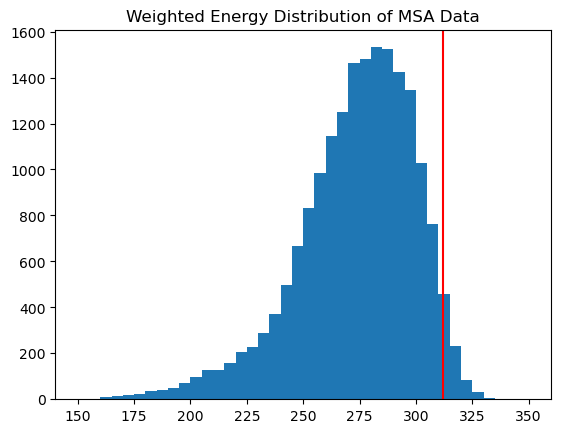

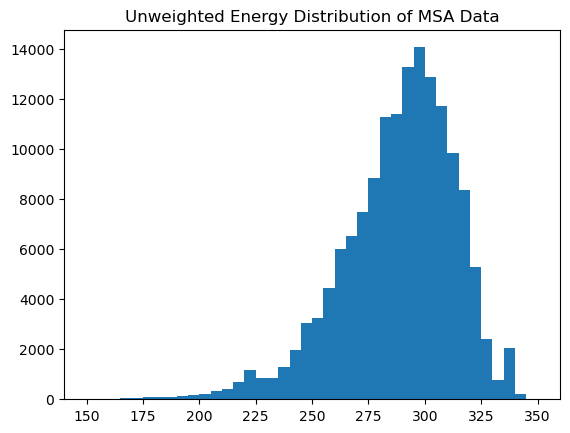

In [108]:
plt.hist(msa_energies[:, 0], weights=w_full_valid, bins=40, range=(150, 350))

plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
plt.title("Weighted Energy Distribution of MSA Data")
# plt.yscale('log')
plt.show()

# plt.hist(mutant_energies[:, 0])
plt.hist(msa_energies[:, 0], bins=40, range=(150, 350))
plt.title("Unweighted Energy Distribution of MSA Data")
# plt.yscale('log')
plt.show()

In [82]:
msa_energies_10000 = mod_hamiltonians(S, c2.J_ij, c2.h_i)

In [83]:
# process weights of c2
w_10000_valid = []
for _w in w_10000:
    if _w != 0:
        w_10000_valid.append(1/_w)

In [94]:
# len(w_10000_valid)
# sum(w_10000_valid)
print(type(w_10000_valid))
a = 0
for _ in w_10000_valid:
    a+=_
print(a)

<class 'list'>
890.7554558888035


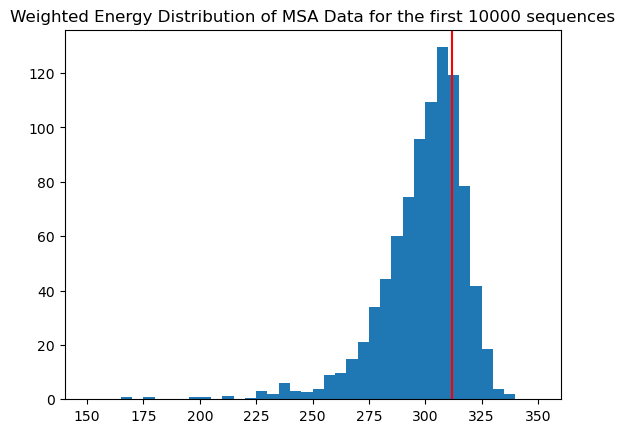

In [109]:
plt.hist(msa_energies[:9954, 0], weights=w_10000_valid, bins=40, range=(150, 350))

plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
plt.title("Weighted Energy Distribution of MSA Data for the first 10000 sequences")
# plt.yscale('log')
plt.show()

In [98]:
### train a model on the 10000-20000th sequences to get the weights
fasta_sequences = SeqIO.parse(open("PABP_YEAST/data/PABP_YEAST.a2m"),'fasta')
with open(f"PABP_YEAST/data/PABP_YEAST_20000.a2m", "w+") as out_file:
    cnt = 0
    seq = []
    for fasta in fasta_sequences:
        if 10000 <= cnt < 20000:
            seq.append(fasta)
        elif cnt >= 20000:
            break
        cnt += 1
    SeqIO.write(seq, out_file, "fasta")

In [99]:
### training code for model
!plmc/bin/plmc -o PABP_YEAST/model/PABP_YEAST_20000.model_params -c PABP_YEAST/model/PABP_YEAST_20000.txt -f PABP_YEAST -le 16.2 -lh 0.01 -m 200 -t 0.2 -g PABP_YEAST/data/PABP_YEAST_20000.a2m

Could not find PABP_YEAST, proceeding without focus sequence
9981 valid sequences out of 10000 
96 sites
Effective number of samples (to 1 decimal place): 1650.4	(80% identical neighborhood = 1.000 samples)
iter	time	cond	fx	-loglk	||h||	||e||
1	0.1	133.61	251977.1	251903.5	75.8	1.0
2	0.2	264.45	214879.9	211505.1	75.8	14.3
3	0.3	117.96	191483.5	184657.1	75.8	20.4
4	0.4	77.34	182756.4	176636.3	75.8	19.3
5	0.5	120.05	177530.6	172343.6	75.7	17.8
6	0.6	49.14	171495.0	165460.1	75.7	19.2
7	0.7	45.67	166115.5	158693.8	75.7	21.3
8	0.8	48.67	155128.2	141933.1	75.7	28.5
9	1.0	68.16	151418.0	134761.2	75.6	32.0
10	1.1	49.19	146911.8	126827.8	75.6	35.2
11	1.2	50.65	141938.8	116177.8	75.6	39.8
12	1.3	34.54	138827.0	111910.1	75.6	40.7
13	1.4	29.44	136978.1	111007.6	75.6	40.0
14	1.5	50.63	135048.1	109196.7	75.6	39.9
15	1.6	25.26	132961.0	106540.1	75.6	40.3
16	1.7	20.22	132062.8	104419.1	75.6	41.3
17	1.8	18.87	130541.3	99555.9	75.6	43.7
18	2.0	23.99	129960.2	97323.4	75.5	44.8
19	2.1	14.75	129390.8	9558

In [104]:
c3 = CouplingsModel("PABP_YEAST/model/PABP_YEAST_10000.model_params")
w_20000 = c3.weights
w_20000_valid = []
for i in range(c2.weights.shape[0]):
    if w_20000[i] == 0: 
        continue
    w_20000[i] = 1/w_20000[i]
    w_20000_valid.append(w_20000[i])


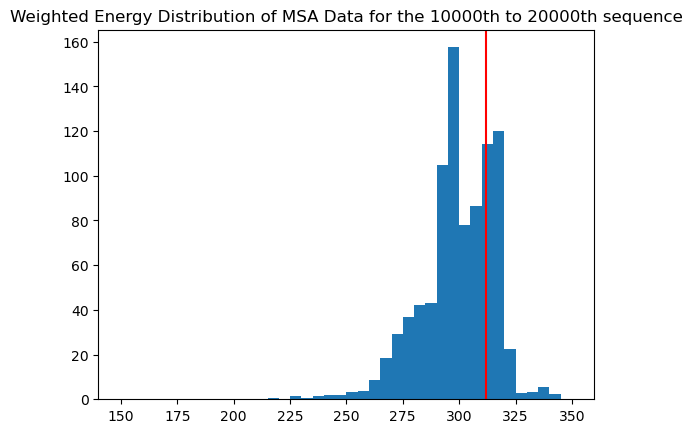

In [107]:
plt.hist(msa_energies[len(w_10000_valid):len(w_10000_valid)+len(w_20000_valid), 0], weights=w_20000_valid, bins=40, range=(150, 350))

plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
plt.title("Weighted Energy Distribution of MSA Data for the 10000th to 20000th sequence")
# plt.yscale('log')
plt.show()